### Define dynamics, starting with 1 mode

In [249]:
import torch

### Dimensionality
state_dim = 2
readout_dim = 2
num_modes = 4

### Transition (A)
#all_ar_transitions_eigvects = torch.randn(num_modes, state_dim, state_dim).to(torch.complex32)
#eig_args = torch.rand(num_modes, state_dim) * 2 * torch.pi
#eig_mags = torch.rand(num_modes, state_dim) * 0.5 + 0.5
#all_ar_transitions_eigvals = (eig_mags * eig_args.cos()) + (1j * (eig_mags * eig_args.sin()))
#all_ar_transitions = torch.einsum('bed,bde->bde', all_ar_transitions_eigvects, (torch.einsum('bd,bde->bde', all_ar_transitions_eigvals, all_ar_transitions_eigvects))).real
transition_mags = torch.rand(num_modes, 1, 2) * 0.3 + 0.6
# transition_angs = torch.rand(num_modes) * (0.25 * torch.pi) + (0.75 * torch.pi)
transition_angs = torch.rand(num_modes) * (0.2 * torch.pi)
transition_angs[:num_modes//2] *= -1.

all_ar_transitions = transition_mags * torch.stack([
    torch.stack([transition_angs.cos(), transition_angs.sin()], -1),
    torch.stack([-transition_angs.sin(), transition_angs.cos()], -1),
], -1)


### Readout (C)
# all_readouts = torch.randn(num_modes, readout_dim, state_dim) * 1.5
all_readouts = torch.eye(readout_dim).unsqueeze(0).repeat(num_modes, 1, 1)

### Transition noise (R) and readout noise (S)
R_chols = torch.eye(state_dim) * 0.1
R_cvar = torch.einsum('ac,dc->ad', R_chols, R_chols)
S_chols = torch.eye(readout_dim) * 2.0
S_cvar = torch.einsum('ac,dc->ad', S_chols, S_chols)

### Init state std (spherical)
inital_state_std = 10.0

### Run dynamics

In [258]:
batch_size = 256

real_mode = torch.randint(0, num_modes, [batch_size])
real_ar_transitions = all_ar_transitions[real_mode]
real_readouts = all_readouts[real_mode]

init_state = torch.randn(batch_size, state_dim) * inital_state_std
init_obs = torch.einsum('bod,bd->bo', real_readouts, init_state)
init_obs_noise = torch.randn(batch_size, readout_dim) @ S_chols.T

# x0
all_state_rollout = [init_state]
all_obs = [init_obs + init_obs_noise]

timesteps = 10

# x1, ..., xT
for t in range(timesteps):
    next_state = torch.einsum('bed,bd->be', real_ar_transitions, all_state_rollout[-1])
    next_obs = torch.einsum('bod,bd->bo', real_readouts, next_state)
    state_noise = torch.randn(batch_size, state_dim) @ R_chols.T
    obs_noise = torch.randn(batch_size, readout_dim) @ S_chols.T
    all_state_rollout.append(next_state + state_noise)
    all_obs.append(next_obs + obs_noise)

all_state_rollout = torch.stack(all_state_rollout, 1)
all_obs = torch.stack(all_obs, 1)

print(all_state_rollout.shape)
print(all_obs.shape)

torch.Size([256, 11, 2])
torch.Size([256, 11, 2])


(-5.676283359527588, 5.676283359527588)

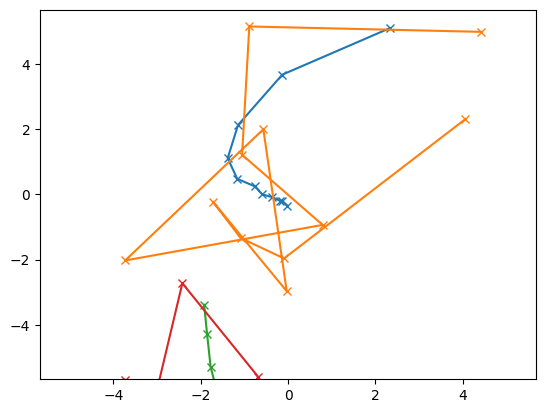

In [259]:
import matplotlib.pyplot as plt
# from ddpm.utils import symmetrize_and_square_axis

fig, axes = plt.subplots(1)
axes.plot(*all_state_rollout[0].T, marker = 'x')
if readout_dim == 2:
    axes.plot(*all_obs[0].T, marker = 'x')

axes.plot(*all_state_rollout[3].T, marker = 'x')
if readout_dim == 2:
    axes.plot(*all_obs[3].T, marker = 'x')

max_size = all_obs[0].abs().max() * 1.1
axes.set_xlim(-max_size, max_size)
axes.set_ylim(-max_size, max_size)

### Run filtering

In [260]:
from tqdm import tqdm

posterior_means = torch.zeros(batch_size, num_modes, timesteps + 1, state_dim)
posterior_cvars = torch.zeros(batch_size, num_modes, timesteps + 1, state_dim, state_dim)
posterior_cvars[:,:,0] = torch.eye(state_dim)[None,None] * 0.1 #  * (inital_state_std ** 2)
posterior_means[:,:,0] = all_obs[:,0].unsqueeze(1)

kalman_gains = torch.zeros(batch_size, num_modes, timesteps, state_dim, state_dim)

prediction_means = torch.zeros(batch_size, num_modes, timesteps, state_dim)
prediction_cvars = torch.zeros(batch_size, num_modes, timesteps, state_dim, state_dim)

y_extend_means = torch.zeros(batch_size, num_modes, timesteps, state_dim)
# y_extend_cvars = torch.zeros(batch_size, num_modes, timesteps, state_dim, state_dim) --> same as Kalman gain inner!

mode_probabilities = torch.zeros(batch_size, num_modes, timesteps+1)
mode_probabilities[:,:,0] = torch.randn(batch_size, num_modes).softmax(-1) # 1./num_modes


for t in tqdm(range(timesteps)):
    prediction_means[:,:,t] = torch.einsum('med,bmd->bme', all_ar_transitions, posterior_means[:,:,t])
    prediction_cvars[:,:,t] = R_cvar[None,None] + torch.einsum('mij,bmjk,mlk->bmil', all_ar_transitions, posterior_cvars[:,:,t], all_ar_transitions)

    kalman_gain_inner = S_cvar[None,None] + torch.einsum('mij,bmjk,mlk->bmil', all_readouts, prediction_cvars[:,:,t], all_readouts)
    kalman_gains[:,:,t] = torch.einsum('bmij,moj,bmop->bmip', prediction_cvars[:,:,t], all_readouts, torch.inverse(kalman_gain_inner))

    posterior_cvars[:,:,t+1] = prediction_cvars[:,:,t] - torch.einsum('bmij,mjk,bmkl->bmil', kalman_gains[:,:,t], all_readouts, prediction_cvars[:,:,t]) # Not transposed this time

    error_term = all_obs[:,t+1].unsqueeze(1) - torch.einsum('mod,bmd->bmo', all_readouts, prediction_means[:,:,t])
    posterior_means[:,:,t+1] = prediction_means[:,:,t] + torch.einsum('bmij,bmj->bmi', kalman_gains[:,:,t], error_term)

    y_extend_means[:,:,t] = torch.einsum('mod,bmd->bmo', all_readouts, prediction_means[:,:,t])

    corrected_kalman_gain_inner = kalman_gain_inner + torch.eye(readout_dim)[None,None] * 2.0
    unnormed_mode_probabilities = torch.distributions.MultivariateNormal(loc = y_extend_means[:,:,t], covariance_matrix=kalman_gain_inner).log_prob(all_obs[:,t+1].unsqueeze(1))
    unnormed_mode_probabilities = unnormed_mode_probabilities.exp() * mode_probabilities[:,:,t]
    mode_probabilities[:,:,t+1] = unnormed_mode_probabilities / unnormed_mode_probabilities.sum(-1, keepdims = True)

100%|██████████| 10/10 [00:00<00:00, 136.27it/s]


(-5.676283359527588, 5.676283359527588)

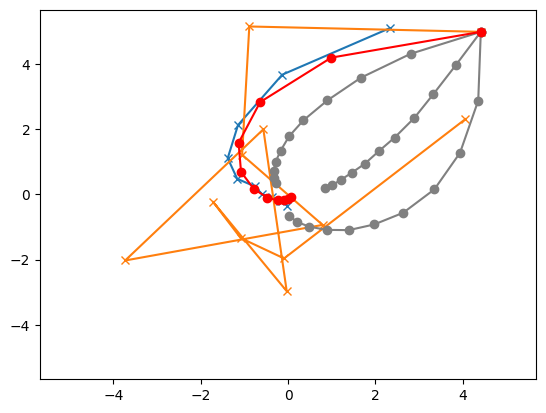

In [261]:

fig, axes = plt.subplots(1)

batch_idx = 0

axes.plot(*all_state_rollout[batch_idx].T, marker = 'x')
if readout_dim == 2:
    axes.plot(*all_obs[batch_idx].T, marker = 'x')
for m in range(num_modes):
    axes.plot(*posterior_means[batch_idx,m].T, marker = 'o', color = 'red' if m == real_mode[batch_idx] else 'grey')

max_size = all_obs[batch_idx].abs().max() * 1.1
axes.set_xlim(-max_size, max_size)
axes.set_ylim(-max_size, max_size)

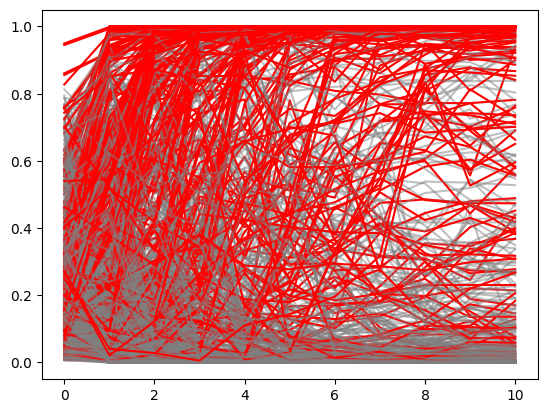

In [262]:
for batch_of_mode_probabilities, rm in zip(mode_probabilities, real_mode):
    for jj, single_mode_batch_of_mode_probabilities in enumerate(batch_of_mode_probabilities):
        color = 'red' if rm == jj else 'grey'
        alpha = 1.0 if rm == jj else 0.5
        plt.plot(single_mode_batch_of_mode_probabilities, color = color, alpha = alpha)

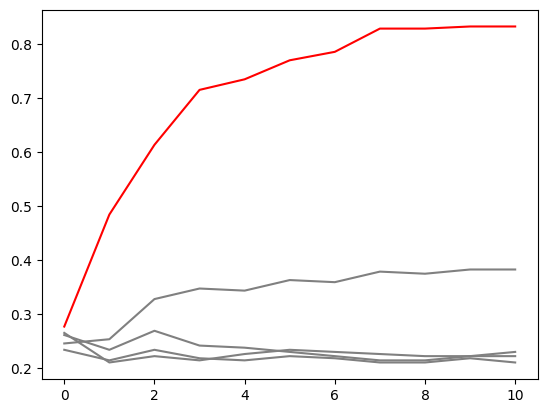

In [263]:
plt.plot((mode_probabilities.argmax(1) == real_mode.unsqueeze(1)).float().mean(0), color = 'red')

for i in range(1, 1+num_modes):
    plt.plot((mode_probabilities.argmax(1) == ((real_mode + i) // num_modes).unsqueeze(1)).float().mean(0), color = 'grey')

11it [00:00, 164.79it/s]


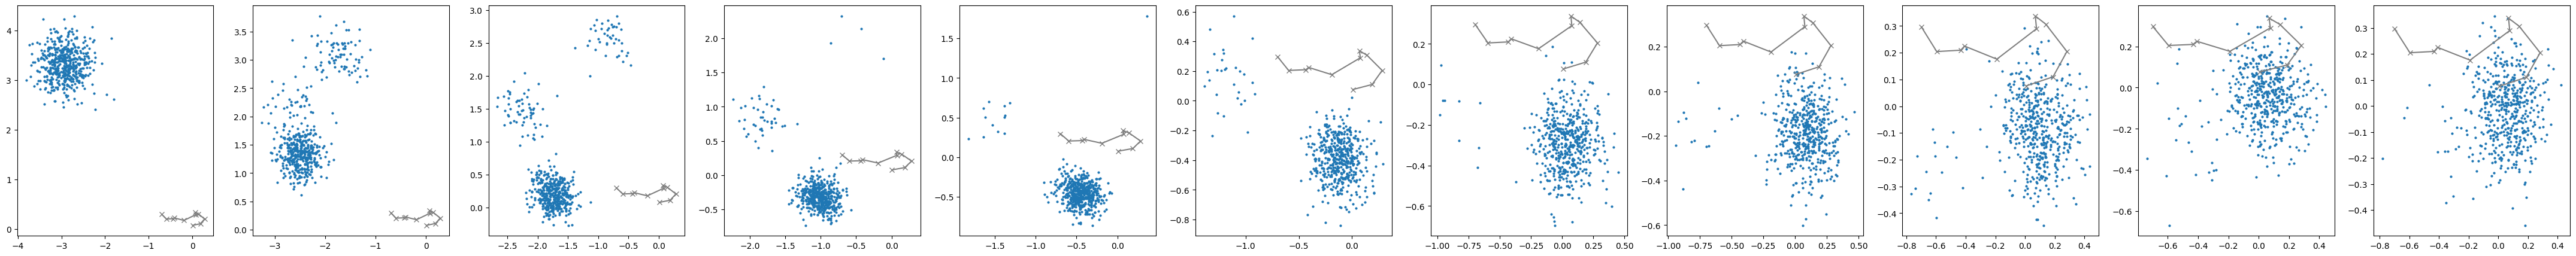

In [265]:
fig, axes = plt.subplots(1, timesteps+1, figsize = (5 * timesteps + 5, 5))
num_samples = 512

batch_idx = torch.stack([mp[rm] for mp, rm in zip(mode_probabilities, real_mode)]).mean(-1).argmin().item()

for t, ax in tqdm(enumerate(axes)):

    mode_probabilities[batch_idx,:,t]
    # print(mode_probabilities[batch_idx,:,t])
    selected_modes = torch.multinomial(mode_probabilities[batch_idx,:,t], num_samples, replacement=True)    # Mode selected for that 'estimate'

    selected_mode_means = posterior_means[batch_idx,selected_modes,t,:]
    selected_mode_cvars = posterior_cvars[batch_idx,selected_modes,t]
    samples = torch.distributions.MultivariateNormal(loc = selected_mode_means, scale_tril=torch.linalg.cholesky(selected_mode_cvars)).sample([])

    ax.scatter(*samples.T, s = 4)
    ax.plot(*all_state_rollout[batch_idx].T, marker = 'x', color = 'grey')

    # samples = torch.distributions.MultivariateNormal(loc = )
    